In [34]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import os
import matplotlib.gridspec as gridspec
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from glob import glob
import numpy as np
import geopandas as gpd

In [2]:
parent_dir    = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir      = os.path.join(parent_dir, 'data')
navis_dir = os.path.join(data_dir, 'navis')
float_dir = os.path.join(data_dir, 'Floats')

In [74]:
dat_1902637 = xr.open_dataset(os.path.join(float_dir, '1902637_Sprof.nc'))
float_1902637 = dat_1902637[['JULD', 'PRES', 'LONGITUDE', 'LATITUDE', 'CHLA']].to_dataframe()
dat_1902637.close()
float_1902637['float'] = '1902637'
float_1902637 = float_1902637[float_1902637['JULD'] == max(float_1902637['JULD'])]

dat_4903532 = xr.open_dataset(os.path.join(float_dir, '4903532_Sprof.nc'))
float_4903532 = dat_4903532[['JULD', 'PRES', 'LONGITUDE', 'LATITUDE', 'CHLA']].to_dataframe()
dat_4903532.close()
float_4903532['float'] = '4903532'
float_4903532 = float_4903532[float_4903532['JULD'] == max(float_4903532['JULD'])]

wmo_dat = pd.concat([float_1902637, float_4903532], ignore_index=True)
wmo_dat = wmo_dat[wmo_dat['PRES'] <= 1000]

In [75]:
df = pd.read_csv(os.path.join(navis_dir, 'merged_table'))
navis_df = df[['JULD', 'lat', 'lon', 'pres', 'Fchl', 'float']]
navis_final = pd.DataFrame(columns = ['JULD', 'lat', 'lon', 'pres', 'Fchl', 'float'])

for i in navis_df['float'].unique():
    temp = navis_df[navis_df['float'] == i]
    temp = temp[temp['JULD'] == max(temp['JULD'])]
    navis_final = pd.concat([navis_final, temp], ignore_index = True)

navis_final.columns = ['JULD', 'LATITUDE', 'LONGITUDE', 'PRES', 'CHLA', 'float']

full_table = pd.concat([wmo_dat, navis_final], ignore_index = True)
position = full_table[['LONGITUDE', 'LATITUDE', 'float']].drop_duplicates()
    

C:\Users\flapet\AppData\Local\Temp\ipykernel_23080\3329202487.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  navis_final = pd.concat([navis_final, temp], ignore_index = True)


In [51]:
satellite_dir = os.path.join(data_dir, 'satellite')
output_dir = os.path.join(parent_dir, 'Output/sat_plot')

#Products come from satellite_data_download.ipynb
chla_data = xr.open_dataset(os.path.join(satellite_dir, 'CMEMS_Iceland_Basin_CHLA_April-May2024.nc'))
#current_data = xr.open_dataset(os.path.join(satellite_dir, 'CMEMS_Iceland_Basin_SSH_April-May2024.nc'))

#Chla colorbar 
color = 'YlGnBu_r'

In [52]:
last_date = chla_data.time[-7:]
# Filter the dataset to only include the last date
chla_data = chla_data.sel(time = last_date)

In [54]:
matrices =chla_data.variables["CHL"][:]

In [55]:
mean_matrix = np.nanmean(matrices, axis=0)

C:\Users\flapet\AppData\Local\Temp\ipykernel_23080\1892043481.py:1: RuntimeWarning: Mean of empty slice
  mean_matrix = np.nanmean(matrices, axis=0)


In [35]:
# Define data's extents I used an arbitrary extent that depicts the Icelandic Bassin
min_lon = -35
max_lon = -5
min_lat = 55
max_lat = 66

# We load shape files for topographic lines
first_line_path = 'c:\\Users\\flapet\\OneDrive - NOC\\Documents\\NRT_viz\\biocarbon_nrt_data_viz/Data/ne_10m_bathymetry_all/ne_10m_bathymetry_J_1000.shp'
second_line_path = 'c:\\Users\\flapet\\OneDrive - NOC\\Documents\\NRT_viz\\biocarbon_nrt_data_viz/Data/ne_10m_bathymetry_all/ne_10m_bathymetry_I_2000.shp'

gdf_1000 = gpd.read_file(first_line_path)
gdf_2000 = gpd.read_file(second_line_path)

In [102]:
plot_1902637 = full_table[full_table['float'] == "1902637"]
date_1902637 = plot_1902637['JULD'].unique()
date_1902637_str = date_1902637[0].strftime("%Y-%m-%d")

plot_4903532 = full_table[full_table['float'] == "4903532"]
date_4903532 = plot_4903532['JULD'].unique()
date_4903532_str = date_4903532[0].strftime("%Y-%m-%d")

plot_101 = full_table[full_table['float'] == 'navis101']
date_101 = plot_101['JULD'].unique()[0][0:10]

plot_102 = full_table[full_table['float'] == 'navis102']
date_102 = plot_102['JULD'].unique()[0][0:10]

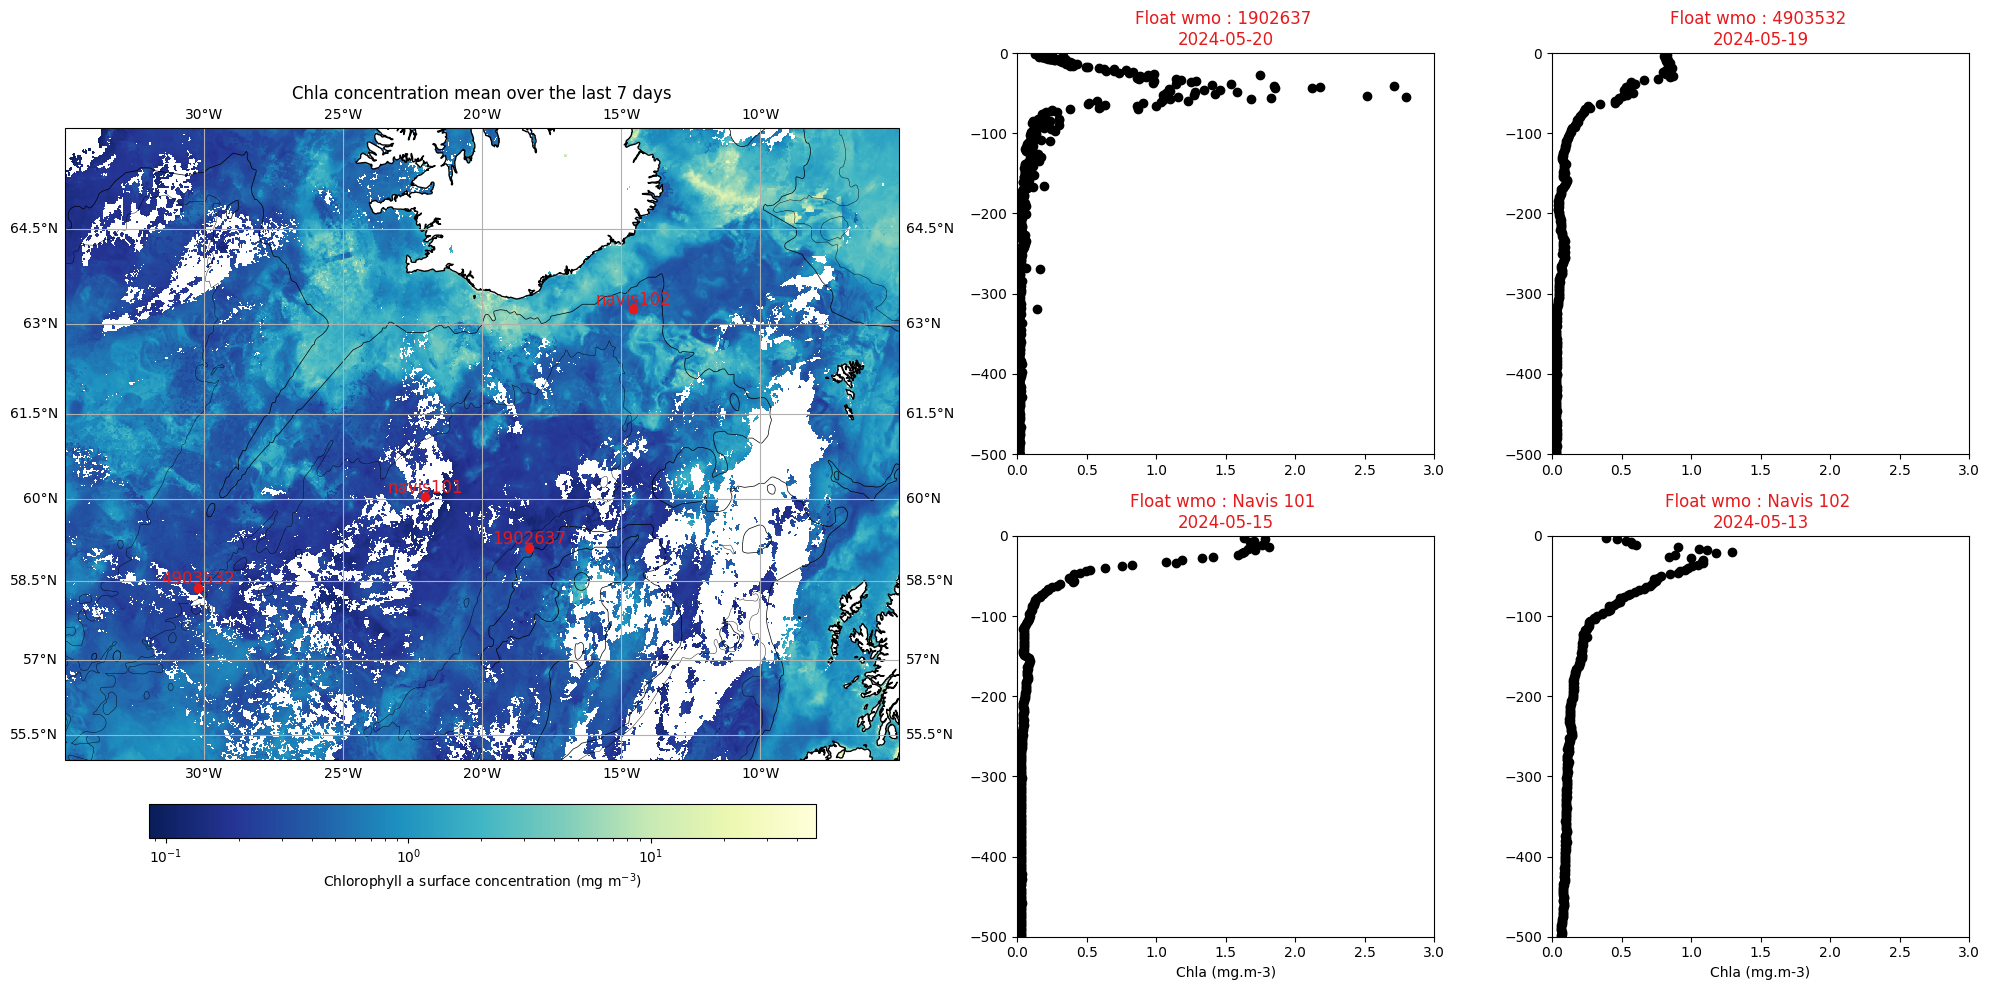

In [104]:
float_colors = {"1902637": "#e41a1c", "4903532": "#4daf4a", "navis101": "#ff7f00", "navis102": "#b15928"}


# Create a figure
fig = plt.figure(figsize=(20, 10))

# Add the large subplot on the left side (occupying both rows)
ax1 = fig.add_subplot(gs[:, 0], projection=ccrs.Mercator())
ax1.plot([0, 1, 2], [0, 1, 0])

# Create a GridSpec with 2 rows and 3 columns
gs = gridspec.GridSpec(2, 3, width_ratios=[2, 1, 1])


# Set the map extent based on your latitude and longitude ranges
ax1.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

im = ax1.pcolormesh(chla_data['longitude'].data, chla_data['latitude'].data, mean_matrix, cmap = color, norm=matplotlib.colors.LogNorm(), transform=ccrs.PlateCarree())
# Add map features
gdf_1000.plot(ax=ax1, transform=ccrs.PlateCarree(), linewidth=0.5, edgecolor='k', facecolor='none')
gdf_2000.plot(ax=ax1, transform=ccrs.PlateCarree(), linewidth=0.3, edgecolor='k', facecolor='none')
ax1.add_feature(cfeature.COASTLINE)

# print a grid on it
gl = ax1.gridlines(draw_labels=True,x_inline=False,y_inline=False, crs=ccrs.PlateCarree())

cbar = plt.colorbar(im, ax = ax1, label=r'Chlorophyll a surface concentration (mg m$^{-3}$)', orientation='horizontal', pad=0.05, shrink = 0.8)
cbar.set_label(r'Chlorophyll a surface concentration (mg m$^{-3}$)')

# Scatter plot
ax1.scatter(position['LONGITUDE'], position['LATITUDE'], c= '#e41a1c', zorder = 3, transform=ccrs.PlateCarree())
for i, (x_, y_, float_name) in enumerate(zip(position['LONGITUDE'], position['LATITUDE'], position['float'])):
    ax1.annotate(float_name, (x_, y_), fontsize=12, ha='center', va='bottom', zorder = 3, transform=ccrs.PlateCarree(), c = '#e41a1c')

# Convert vector bathymetries to raster (saves a lot of disk space)
# while leaving labels as vectors
ax1.set_rasterized(True)
ax1.set_title('Chla concentration mean over the last 7 days')

# Add the smaller subplots on the right side
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])

sc2 = ax2.scatter(plot_1902637["CHLA"], - (plot_1902637['PRES']), c = 'black')
ax2.set_xlim(0, 3)
ax2.set_ylim(-500, 0)
ax2.set_title('Float wmo : 1902637 \n' + date_1902637_str, color = "#e41a1c")

sc3 = ax3.scatter(plot_4903532["CHLA"], - (plot_4903532['PRES']), c = 'black')
ax3.set_xlim(0, 3)
ax3.set_ylim(-500, 0)
ax3.set_title('Float wmo : 4903532 \n' + date_4903532_str, color = "#e41a1c")

sc4 = ax4.scatter(plot_101["CHLA"], - (plot_101['PRES']), c = 'black')
ax4.set_xlim(0, 3)
ax4.set_ylim(-500, 0)
ax4.set_xlabel('Chla (mg.m-3)')
ax4.set_title('Float wmo : Navis 101 \n' + date_101, color = "#e41a1c")


sc5 = ax5.scatter(plot_102["CHLA"], - (plot_102['PRES']), c = 'black')
ax5.set_xlim(0, 3)
ax5.set_ylim(-500, 0)
ax5.set_xlabel('Chla (mg.m-3)')
ax5.set_title('Float wmo : Navis 102 \n' + date_102 , color = "#e41a1c")


# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

